# Rock Physics inversion for water/CO2 saturation from Volcanic attenuation tomography data

In [2]:
from importlib import reload
import volcaniQ as vq
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%load_ext autoreload
%autoreload 2
volcanic_data = vq.CleanReadCSV()
fluids = vq.FluidsReadCSV()
calibration = vq.RockPhysicsModelCalibrator()

## Fluids

First I have loaded some fluids. I have taken the properties of CO<sub>2</sub> and water from the MNIST database, the corresponding CSV file attached is created in Mathematica which relies on MNIST for thermodynamic data. The code in `FluidReadCSV` essentially loads these up. 

***please check these are correct!!***

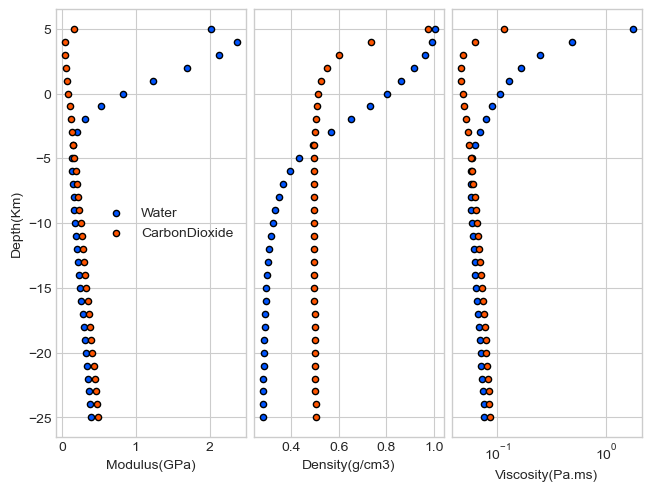

In [3]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(1, 3,constrained_layout = True)

fluid_names = {'Water':  '#0055FF', 'CarbonDioxide':'#FF5500'}
labels = {'Modulus(GPa)':'modulus', 'Density(g/cm3)':'density', 'Viscosity(Pa.ms)': 'viscosity'}

for lab, prop in enumerate(labels):
    for fluid in fluid_names:
        axs[lab].scatter(getattr(fluids(fluid),labels[prop]), -fluids(fluid).depth, c=fluid_names[fluid], s=20, edgecolors='black', label=fluid)
        axs[lab].set_xlabel(prop)

axs[0].legend()
axs[0].set_ylabel('Depth(Km)')

axs[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

axs[2].set_xscale('log')
axs[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

These will need to be combined into an effective fluid for partial saturation. This is done via `EffectiveFluid` class as per below. The two things that affect the squirt flow model, is the effective fluid modulus and the log frequency, both plotted below. The parameter `q` controls how unifrom the saturation is.

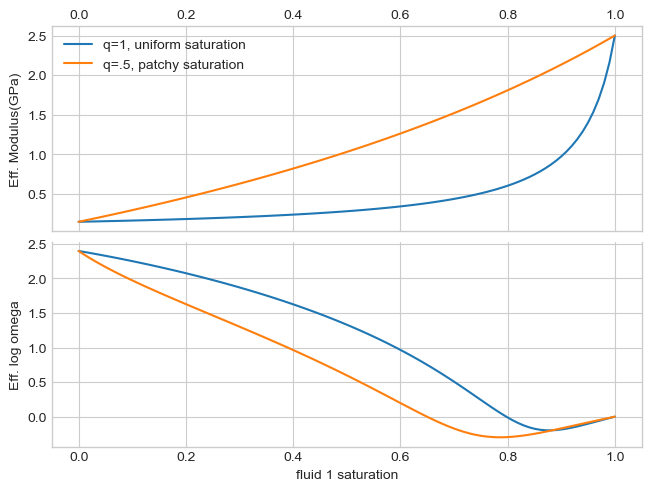

In [360]:
fl1 = vq.Fluid(density=1., viscosity=.5, modulus=2.5)
fl2 = vq.Fluid(density=.5, viscosity=.002, modulus=.15)
flmx = vq.EffectiveFluid(fl1, fl2)
sat = np.arange(0,1.01,.01)
def mod(q): return np.array([flmx(saturation=s, patch_parameter=q).modulus for s in sat])
def log_omega(q): return np.log10(np.array([flmx(saturation=s, patch_parameter=q).omega_c for s in sat]))
fig, ax = plt.subplots(2, 1,constrained_layout = True)
ax[0].plot(sat, mod(1), label='q=1, uniform saturation')
ax[0].plot(sat, mod(.1), label= 'q=.5, patchy saturation')
ax[0].legend()
ax[0].set_ylabel('Eff. Modulus(GPa)')
ax[1].plot(sat, log_omega(1), label='q=1, uniform saturation')
ax[1].plot(sat, log_omega(.1), label= 'q=.5, patchy saturation')
ax[1].set_ylabel('Eff. log omega')
ax[1].set_xlabel('fluid 1 saturation')
# ax[0].spines.bottom.set_visible(False)
ax[1].spines.top.set_visible(False)
ax[0].xaxis.tick_top()

ax[1].tick_params(labeltop=False)

## Model calibration

Now I need to calibrate the model, based on a fluid endpoint and the input parameters that we have. I have written a calibration class for this which is called in `RockPhysicsModelCalibrator()`. The way this works is more or less straightforward, call

        model = calibration(Vp = vp, Vs = vs, Rho = rho, Qp=qp, phi=.15, Kf=kw)

and you get a rock physics model that will have the Qp, Vp, Vs values at a reference frequency, which I have taken to be the squirt flow frequency of water saturated rock. The assumption is that the matrix is quartz 

***does quarz make sense?***

With these assumptions, you can calibrate the model and check it returns the right values when `omegac` (the log squirt flow frequency of water) is zero

In [333]:
ref_vp, ref_vs, ref_rho, ref_qp = 5., 2.3, 2.7, 45
model = calibration(Vp = ref_vp, Vs = ref_vs, Rho = ref_rho, Qp=ref_qp, phi=.34, Kf=2.25)
cij_at_calibration = model(omegac=0., fluid_modulus=2.25).squirt_flow_model(0)
q = (lambda x: np.real(x)/np.imag(x))
tuple(model(omegac=0., fluid_modulus=2.25).squirt_flow_model(0)[[0,5],[0,5]]), (lambda x: np.real(x)/np.imag(x))(model(omegac=0, fluid_modulus=2.25).squirt_flow_model(0)[0,0])
{'model': {"p-modulus":cij_at_calibration[0,0], "s-modulus":cij_at_calibration[5,5], "qp":q(cij_at_calibration[0,0])}, 'observed':{"p-modulus":ref_vp**2*ref_rho, "s-modulus":ref_vs**2*ref_rho, "qp":ref_qp}}

{'model': {'p-modulus': (67.55243689753334+1.5j),
  's-modulus': (14.32232767315001+0.03932767315001126j),
  'qp': 45.03495793168889},
 'observed': {'p-modulus': 67.5, 's-modulus': 14.283, 'qp': 45}}

## The data

There are a couple of crucial questions regarding the data.
 - is the calibration point rightly chosen where the white rectangle is? It seems to be relatively consistent down to about 5 km BSL, relative coordinates `x=17, y=-11`
 - are Qp and Qs derived at the same frequency? I have assumed so, but it is not clear and also the Qp/Qs that the model predicts at the same frequency is realatively constant but can vary wildly if the frequency of measurement of Qp and that of Qs vary by up to an order of magnitude. If that is so, there is some really exciting modelling to be done for the inversion

In [6]:
import plotly.express as px
import plotly.graph_objects as go
xmin, xmax = 15, 18
ymin, ymax = -10, -12
fig = px.scatter(volcanic_data.data[volcanic_data.data['z'] ==-5], x='x', y='y',
              color='Qp')
fig.add_shape(type="rect",
    x0=xmin, y0=ymin, x1=xmax, y1=ymax,
    line=dict(color="White"),
    fillcolor="White",
    opacity=0.7,
)
fig.add_annotation(
            x=16., y=-9,
            text=f"Calibration(100% water)",
            showarrow=True,
            font=dict(
                family="sans-serif",
                size=12,
                color="#ffffff"
            ),
            arrowcolor="#ffffff",
            arrowhead=1)
fig.update_yaxes(
      scaleanchor="x",
      scaleratio=1,
)

fig.show()

## The model calibrated on the data

Noting all the above I have written the below to calibrate the model on the basis that the white calibration square is water only. I have done this for every depth level and for the values of K, mu and Qp that are in the data. I have assumed quartz all the way and constant porosity of 15%.

In [8]:
def calibration_model_by_depth(depth:int, xmin:int, xmax:int, ymin:int, ymax:int):
    # data = volcanic_data.data\
    # [
    # volcanic_data.data["z"].between(depth,depth)
    # ]
    result = volcanic_data.data\
    [
    volcanic_data.data["z"].between(depth,depth) &\
    volcanic_data.data["x"].between(xmin, xmax) &\
    volcanic_data.data["y"].between(ymin, ymax)
    ]\
    .groupby('z')\
    .mean()
    k, rho, mu, qp = tuple(result[['K','ρ', 'μ','Qp']].values[0])
    kw, rhow, etaw = tuple(fluids('Water').temp_df[fluids('Water').temp_df['Depth(Km)']==depth][['Modulus(GPa)', 'Density(g/cm3)', 'Viscosity(Pa.ms)']].values[0])
    kco2, rhoco2, etaco2 = tuple(fluids('CarbonDioxide').temp_df[fluids('CarbonDioxide').temp_df['Depth(Km)']==depth][['Modulus(GPa)', 'Density(g/cm3)', 'Viscosity(Pa.ms)']].values[0])
    water = vq.Fluid(density=rhow, viscosity=etaw, modulus=kw)
    co2 = vq.Fluid(density=rhoco2, viscosity=etaco2, modulus=kco2)
    watCo2mix = vq.EffectiveFluid(water, co2)
    watCo2mix.brooks_corey_lambda = 1.
    vp = np.sqrt((k + 4/3*mu)/rho)
    vs = np.sqrt(mu/rho)
    model = calibration(Vp = vp, Vs = vs, Rho = rho, Qp=qp, phi=.15, Kf=kw)
    def saturation_dependent_model(sw, q):
        mix = watCo2mix(saturation=sw, patch_parameter=q, reference_frequency=1)
        omega_c,fluid_modulus = np.log10(mix.omega_c), mix.modulus
        return model(omegac=omega_c, fluid_modulus=fluid_modulus)
    return saturation_dependent_model

In [9]:
test = calibration_model_by_depth(3, 15, 18, -12, -10)

NameError: name 'test' is not defined

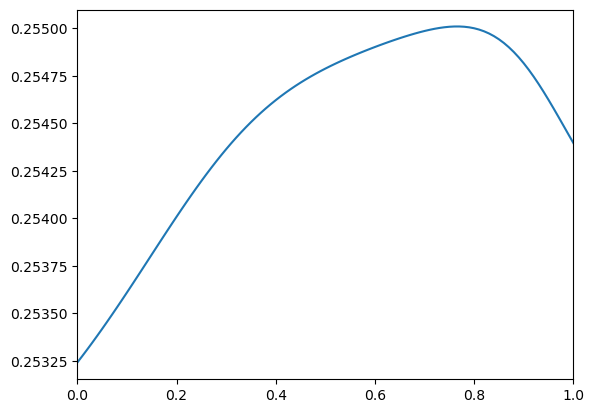

In [281]:
test = calibration_model_by_depth(3, 15, 18, -12, -10)
# test2 = calibration_model_by_depth(10, 6,6,-20,-20)
# test(sw=.1, q=1)
s = np.arange(0,1.01,0.01)
y = np.array([(lambda x: np.real(x)/np.imag(x))(test(s1, 1).squirt_flow_model(0)[0,0]) for s1 in s])
# y2 = [(lambda x: np.real(x)/np.imag(x))(test2(s1, 1).squirt_flow_model(0)[0,0]) for s1 in s]
y3 = np.array([(lambda x: np.real(x)/np.imag(x))(test(s1, 1).squirt_flow_model(0)[5,5]) for s1 in s])
# y4 = [(lambda x: np.real(x)/np.imag(x))(test2(s1, 1).squirt_flow_model(0)[5,5]) for s1 in s]
fig, ax = plt.subplots()
ax.set_xlim(0,1)
# ax.set_ylim(10,10000)
# ax.set_yscale('log')
ax.plot(s, y/y3)
# ax.plot(s, y2)
# ax.plot(s, 1/y3)
# ax.plot(s, y4)

# test(omegac=1, fluid_modulus=2.2).squirt_flow_model(0.)
# test(sw=1, q=1).squirt_flow_model(0.)


In [ ]:
calibrate = vq.RockPhysicsModelCalibrator()
rpm = calibrate(Vp = 3.8, Vs = 2., Rho = 2.7, Qp=5, phi=.2, Kf=2.25)
test = rpm(omegac =0.,fluid_modulus= 2.25)
def test2(sw):
    effC = flmx(saturation = sw).omega_c
    return rpm(omegac = effC, fluid_modulus= 2.25)

np.round(test.squirt_flow_model(2), 3), np.round(test.low_frequency_model, 3)
np.round(test2(1).squirt_flow_model(0), 3)



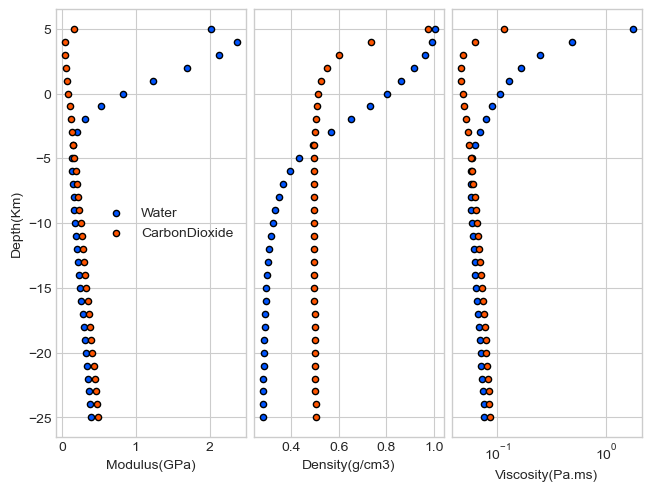

In [97]:
plt.style.use('seaborn-whitegrid')
fig, axs = plt.subplots(1, 3,constrained_layout = True)

fluid_names = {'Water':  '#0055FF', 'CarbonDioxide':'#FF5500'}
labels = {'Modulus(GPa)':'modulus', 'Density(g/cm3)':'density', 'Viscosity(Pa.ms)': 'viscosity'}

for lab, prop in enumerate(labels):
    for fluid in fluid_names:
        axs[lab].scatter(getattr(fluids(fluid),labels[prop]), -fluids(fluid).depth, c=fluid_names[fluid], s=20, edgecolors='black', label=fluid)
        axs[lab].set_xlabel(prop)

axs[0].legend()
axs[0].set_ylabel('Depth(Km)')

axs[1].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

axs[2].set_xscale('log')
axs[2].tick_params(axis='y', which='both', left=False, right=False, labelleft=False)


In [273]:
import plotly.express as px
import plotly.graph_objects as go
xmin, xmax = 15, 18
ymin, ymax = -10, -12
fig = px.scatter(volcanic_data.data[volcanic_data.data['z'] ==5], x='x', y='y',
              color='Qp/Qs')
fig.add_shape(type="rect",
    x0=xmin, y0=ymin, x1=xmax, y1=ymax,
    line=dict(color="White"),
    fillcolor="White",
    opacity=0.7,
)
fig.add_annotation(
            x=16., y=-9,
            text=f"Calibration(100% water)",
            showarrow=True,
            font=dict(
                family="sans-serif",
                size=12,
                color="#ffffff"
            ),
            arrowcolor="#ffffff",
            arrowhead=1)
fig.update_yaxes(
      scaleanchor="x",
      scaleratio=1,
)

fig.show()

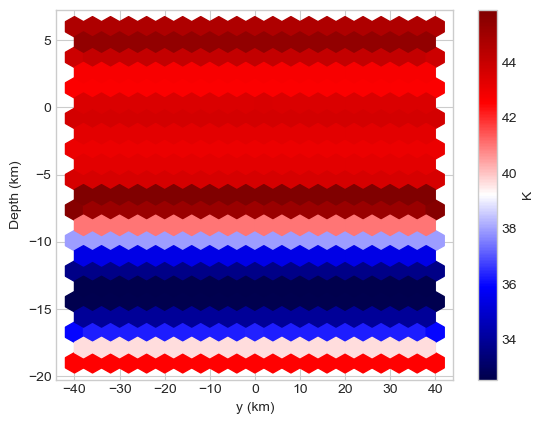

<Figure size 4212x4212 with 0 Axes>

In [281]:
volcanic_data.hexplot(plot="K", direction='x', value=1., grid=20)

<AxesSubplot:xlabel='z'>

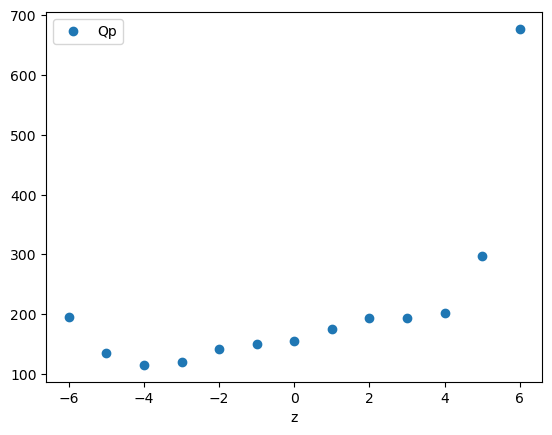

In [151]:
volcanic_data.data\
    [
    volcanic_data.data["z"].between(-6,6) &\
    volcanic_data.data["x"].between(xmin, xmax) &\
    volcanic_data.data["y"].between(ymin, ymax)
    ]\
    .groupby('z')\
    .mean()\
    .plot(y='Qp', style='o')

In [3]:
def avg_values(depth: int) -> dict:
    dict = {}
    temp_data = (volcanic_data.data['z'] == depth)
    Qp = volcanic_data.data[temp_data & (volcanic_data.data['Qp'].notna())]["Qp"].min()
    Qs = volcanic_data.data[temp_data & volcanic_data.data['Qs'].notna()]["Qs"].min()
    K = volcanic_data.data[temp_data & volcanic_data.data['K'].notna()]["K"].mean()
    mu = volcanic_data.data[temp_data & volcanic_data.data['μ'].notna()]["μ"].mean()
    rho = volcanic_data.data[temp_data & volcanic_data.data['μ'].notna()]["ρ"].mean()
    dict['Qp'] = Qp
    dict['Qs'] = Qs
    dict['K'] = K
    dict['mu'] = mu
    dict['rho'] = rho
    return dict
avg_values(1)
   

{'Qp': 42.93, 'Qs': 40.93, 'K': 43.67, 'mu': 26.5, 'rho': 2.649999999999999}

In [242]:
volcanic_data.data['K/mu'] = volcanic_data.data['K']/volcanic_data.data['μ']

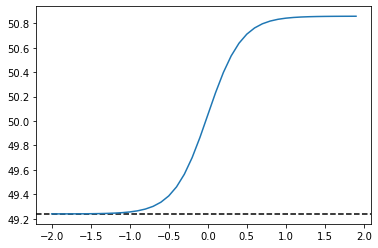

In [68]:
model1 = vq.RockPhysicsModel(dry_modulus=20.,shear_modulus=20, mineral_modulus=38, porosity=0.2, density=2.65)
model1.plot(fluid_modulus=2.5, epsilon=.03, tau=1)

In [66]:
highQpdata = data.data[data.data.Qp.notnull()][data.data.Qp>800]
highQsdata = data.data[data.data.Qp.notnull()][data.data.Qs>1000]
mod = highQpdata.K
she = highQsdata.μ
mod.mean(), she.mean()

<ipython-input-66-49cd03391929>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highQpdata = data.data[data.data.Qp.notnull()][data.data.Qp>800]
<ipython-input-66-49cd03391929>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highQsdata = data.data[data.data.Qp.notnull()][data.data.Qs>1000]


(43.68873573573574, 26.02604200853298)